# 🎉 Out-of-Distribution (OOD) with PCA using Deep Features from the Latent Space

The goal of this notebook is to understand the depths of using Principal Component Analysis in order to perform OOD tasks using deep features from the latent space

## 📝 Plan of action

### ♻️ Preprocessing phase

In order to achieve our goal, we need to understand how the dataset is structured.

For this notebook, we are going to use the CBIR 15 dataset, that contains images of different places, such as an office, a bedroom, a mountain, etc. Note that there are some places that are similar one to another, i.e. a bedroom and a living room.

Thus, in order to extract the features of the images we have to preprocess those images:

- Get the images that are located in data/CBIR_15-scene and fit them to a dataframe using Pandas
  - Locate the "Labels.txt" file: it shows where the indexes of the images from each category starts
- Create the dataset with this information with two columns: the path to the image and its category
- Transform all of the images in the same size (in this case, we are going with 256x256)
  
Now, in order to extract the features, it's necessary to divide the reshaped images into patches of 32x32 pixels. This is good to perform processing tasks to avoid waiting long periods of time.

After all the preprocess, we should separate the images into two different foldes: one contains the patches of the training images that is going to give us their principal components and dimensions, and the other is the patches of the test images, that is going to be tested to fit into those dimensions and we'll get an OOD score afterwards.

### 🏋🏽‍♂️ Training phase

With the images that are stored inside the "patches_train" folder, the first thing we are going to do is _normalize_ all of the images to find the correct maximum covariance and transforming all the variables into the same scale.

Next, we should then apply the PCA with all the components. As we have patches of 32x32, we'll be having 1024 features, hence components. Then we plot a graph to see how many components truly contributes for the most variance of the data - and give us more information about it. We're going to take the threshold of 95% of variance in this notebook.

After getting the PCA with components that describe 95% of the variance, it's time to test our images and see how far of the residual space their data can be found.

### ⚗️ Test phase and results

In this phase, we take the test images and normalize then with the same scale of each PCA. This is important to maintain consistency throughout the final results and measure the norms in the new dimension properly.

After that, we calculate the norm of the projection of the given data into the orthogonal space of the principal component and divide it by the norm of the data in relation to the origin. This is the OOD score.

We calculate the mean of the score for each category and get the minimal one. The current environment is the smallest.


--------------------------

First of all, we need to understand which libraries we are going to use:

- os: Deals with the operation system interface such as finding the relative and absolute path of files inside a project and reading/writing files for example.
- sys: This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
- numpy: NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.
- pandas: Pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- matplotlib: Deals with plotting graphs to visualize data in a graphical way.
- sklearn: Scikit-learn provides dozens of built-in machine learning algorithms and models, called estimators.

In [4]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


I'd suggest to use a conda virtual environment in order to avoid messing up your base kernel environment and causing dependency errors in the future.

After you successfully installed all the modules, it's time to import our custom modules that are going to deal with:

- Creation of our dataframe using pandas
- Separation of our dataset into patches of 32x32 in folders of training and test

In [5]:

sys.path.append(os.path.abspath('..'))

from dataframe_generator import *
from image_patching import *

In [6]:
import tarfile

def extract_tgz(tgz_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_to)
        print(f"Arquivos extraídos para {extract_to}")

tgz_path = '../CBIR_15-Scene.tgz'
extract_to = '../data/'

extract_tgz(tgz_path, extract_to)

Arquivos extraídos para ../data/


In [7]:
df, split_variables = create_dataframe()
df

                             image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]


,image_path,category
0,../data/CBIR_15-Scene/00/1.jpg,Bedroom
1,../data/CBIR_15-Scene/00/2.jpg,Bedroom
2,../data/CBIR_15-Scene/00/3.jpg,Bedroom
3,../data/CBIR_15-Scene/00/4.jpg,Bedroom
4,../data/CBIR_15-Scene/00/5.jpg,Bedroom
...,...,...
4480,../data/CBIR_15-Scene/14/4481.jpg,Store
4481,../data/CBIR_15-Scene/14/4482.jpg,Store
4482,../data/CBIR_15-Scene/14/4483.jpg,Store
4483,../data/CBIR_15-Scene/14/4484.jpg,Store


## ☝️ Part I: Comparing two different environments

### ♻️ Preprocessing phase

Now we start our experiments to understand if our idea work, however this time we are going to understand what happens with our approach using two different environments.

In our case, I'm going to take the **Coast** and **Office** environments arbitrarily.


In [8]:
train_categories = ['Coast', 'Office']

df_different = df[df['category'].isin(train_categories)]
df_different

,image_path,category
1267,../data/CBIR_15-Scene/05/1268.jpg,Coast
1268,../data/CBIR_15-Scene/05/1269.jpg,Coast
1269,../data/CBIR_15-Scene/05/1270.jpg,Coast
1270,../data/CBIR_15-Scene/05/1271.jpg,Coast
1271,../data/CBIR_15-Scene/05/1272.jpg,Coast
...,...,...
4165,../data/CBIR_15-Scene/13/4166.jpg,Office
4166,../data/CBIR_15-Scene/13/4167.jpg,Office
4167,../data/CBIR_15-Scene/13/4168.jpg,Office
4168,../data/CBIR_15-Scene/13/4169.jpg,Office


It's time to separate our dataset into train and test. We should use the built-in function of sklearn to do this:

In [9]:
X = df_different['image_path']
y = df_different['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)


Making sure that everything went well, we plot the grid of all the patches from the first image of our training set

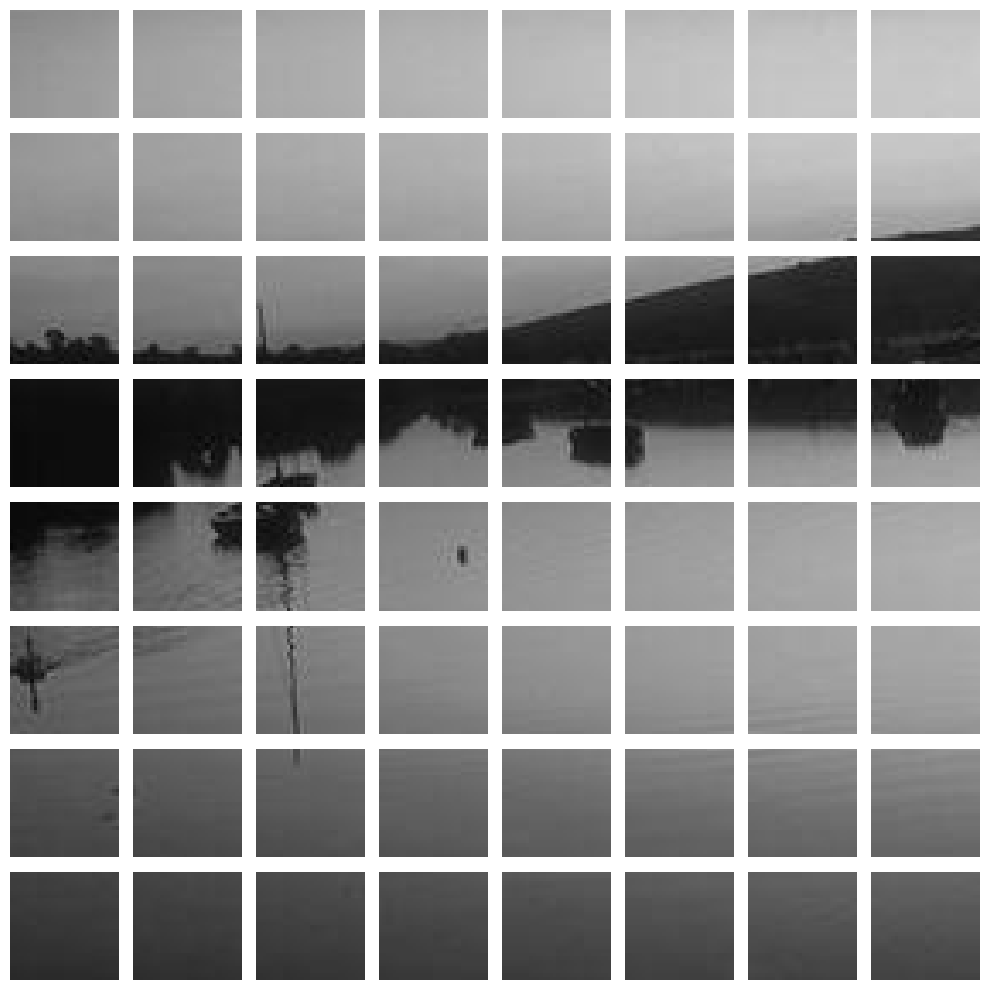

In [10]:
def plot_patches_grid(patches, patch_size, grid_shape):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(10, 10))
    patch_idx = 0
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            if patch_idx < len(patches):
                axes[i, j].imshow(cv2.cvtColor(patches[patch_idx], cv2.COLOR_BGR2RGB))
                axes[i, j].axis('off')
                patch_idx += 1
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

patch_size = (32,32)

first_image_path = X_train.iloc[0]
image = cv2.imread(first_image_path)
resized_image = resize_image(image, standard_size)
patches, positions = create_patches(resized_image, patch_size)

grid_rows = resized_image.shape[0] // patch_size[0]
grid_cols = resized_image.shape[1] // patch_size[1]

plot_patches_grid(patches, patch_size, (grid_rows, grid_cols))


This is exactly what the module that's inside our "image_patching.py" do. So we now, need to save everything into the subfolders by calling that function:

In [11]:
create_images_set(X_train, X_test, y_train, y_test, patch_size, output_dir_train='patches_train', output_dir_test='patches_test')

Now, we should load our patches for training:

In [12]:
training_patches_by_category = load_patches_by_category('patches_train', y, patch_size)